### Data Dictionary

We will be using the dataset baseball.csv. Download this dataset to follow along in R as we build regression models. This data comes from Baseball-Reference.com. We will predict Wins (W)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("baseball.csv")

In [3]:
df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,SFG,NL,1999,872,831,86,0.356,0.434,0.271,0,NaN,NaN,162,0.345,0.423
416,STL,NL,1999,809,838,75,0.338,0.426,0.262,0,NaN,NaN,161,0.355,0.427
417,TBD,AL,1999,772,913,69,0.343,0.411,0.274,0,NaN,NaN,162,0.371,0.448
418,TEX,AL,1999,945,859,95,0.361,0.479,0.293,1,5.0,4.0,162,0.346,0.459


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          420 non-null    object 
 1   League        420 non-null    object 
 2   Year          420 non-null    int64  
 3   RS            420 non-null    int64  
 4   RA            420 non-null    int64  
 5   W             420 non-null    int64  
 6   OBP           420 non-null    float64
 7   SLG           420 non-null    float64
 8   BA            420 non-null    float64
 9   Playoffs      420 non-null    int64  
 10  RankSeason    114 non-null    float64
 11  RankPlayoffs  114 non-null    float64
 12  G             420 non-null    int64  
 13  OOBP          420 non-null    float64
 14  OSLG          420 non-null    float64
dtypes: float64(7), int64(6), object(2)
memory usage: 49.3+ KB


In [5]:
df.describe(include='all')

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,420,420,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,114.000000,114.000000,420.000000,420.000000,420.000000
unique,34,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,DET,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2005.500000,759.538095,759.538095,80.957143,0.332300,0.419729,0.263638,0.271429,3.649123,3.157895,161.942857,0.332264,0.419743
std,NaN,NaN,4.035936,83.527087,87.636758,11.642162,0.014005,0.026100,0.011584,0.445227,1.838538,1.077353,0.347609,0.015295,0.026510
min,NaN,NaN,1999.000000,513.000000,529.000000,43.000000,0.292000,0.339000,0.233000,0.000000,1.000000,1.000000,161.000000,0.294000,0.346000
25%,NaN,NaN,2002.000000,706.000000,697.000000,72.000000,0.322000,0.401750,0.256000,0.000000,2.000000,3.000000,162.000000,0.321000,0.401000
50%,NaN,NaN,2005.500000,752.500000,754.500000,81.000000,0.332000,0.420000,0.263000,0.000000,4.000000,4.000000,162.000000,0.331000,0.419000
75%,NaN,NaN,2009.000000,813.000000,823.500000,90.000000,0.341000,0.437000,0.271000,1.000000,5.000000,4.000000,162.000000,0.343000,0.438000


In [6]:
df.shape

(420, 15)

In [7]:
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'RankSeason', 'RankPlayoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

### Data Visualization

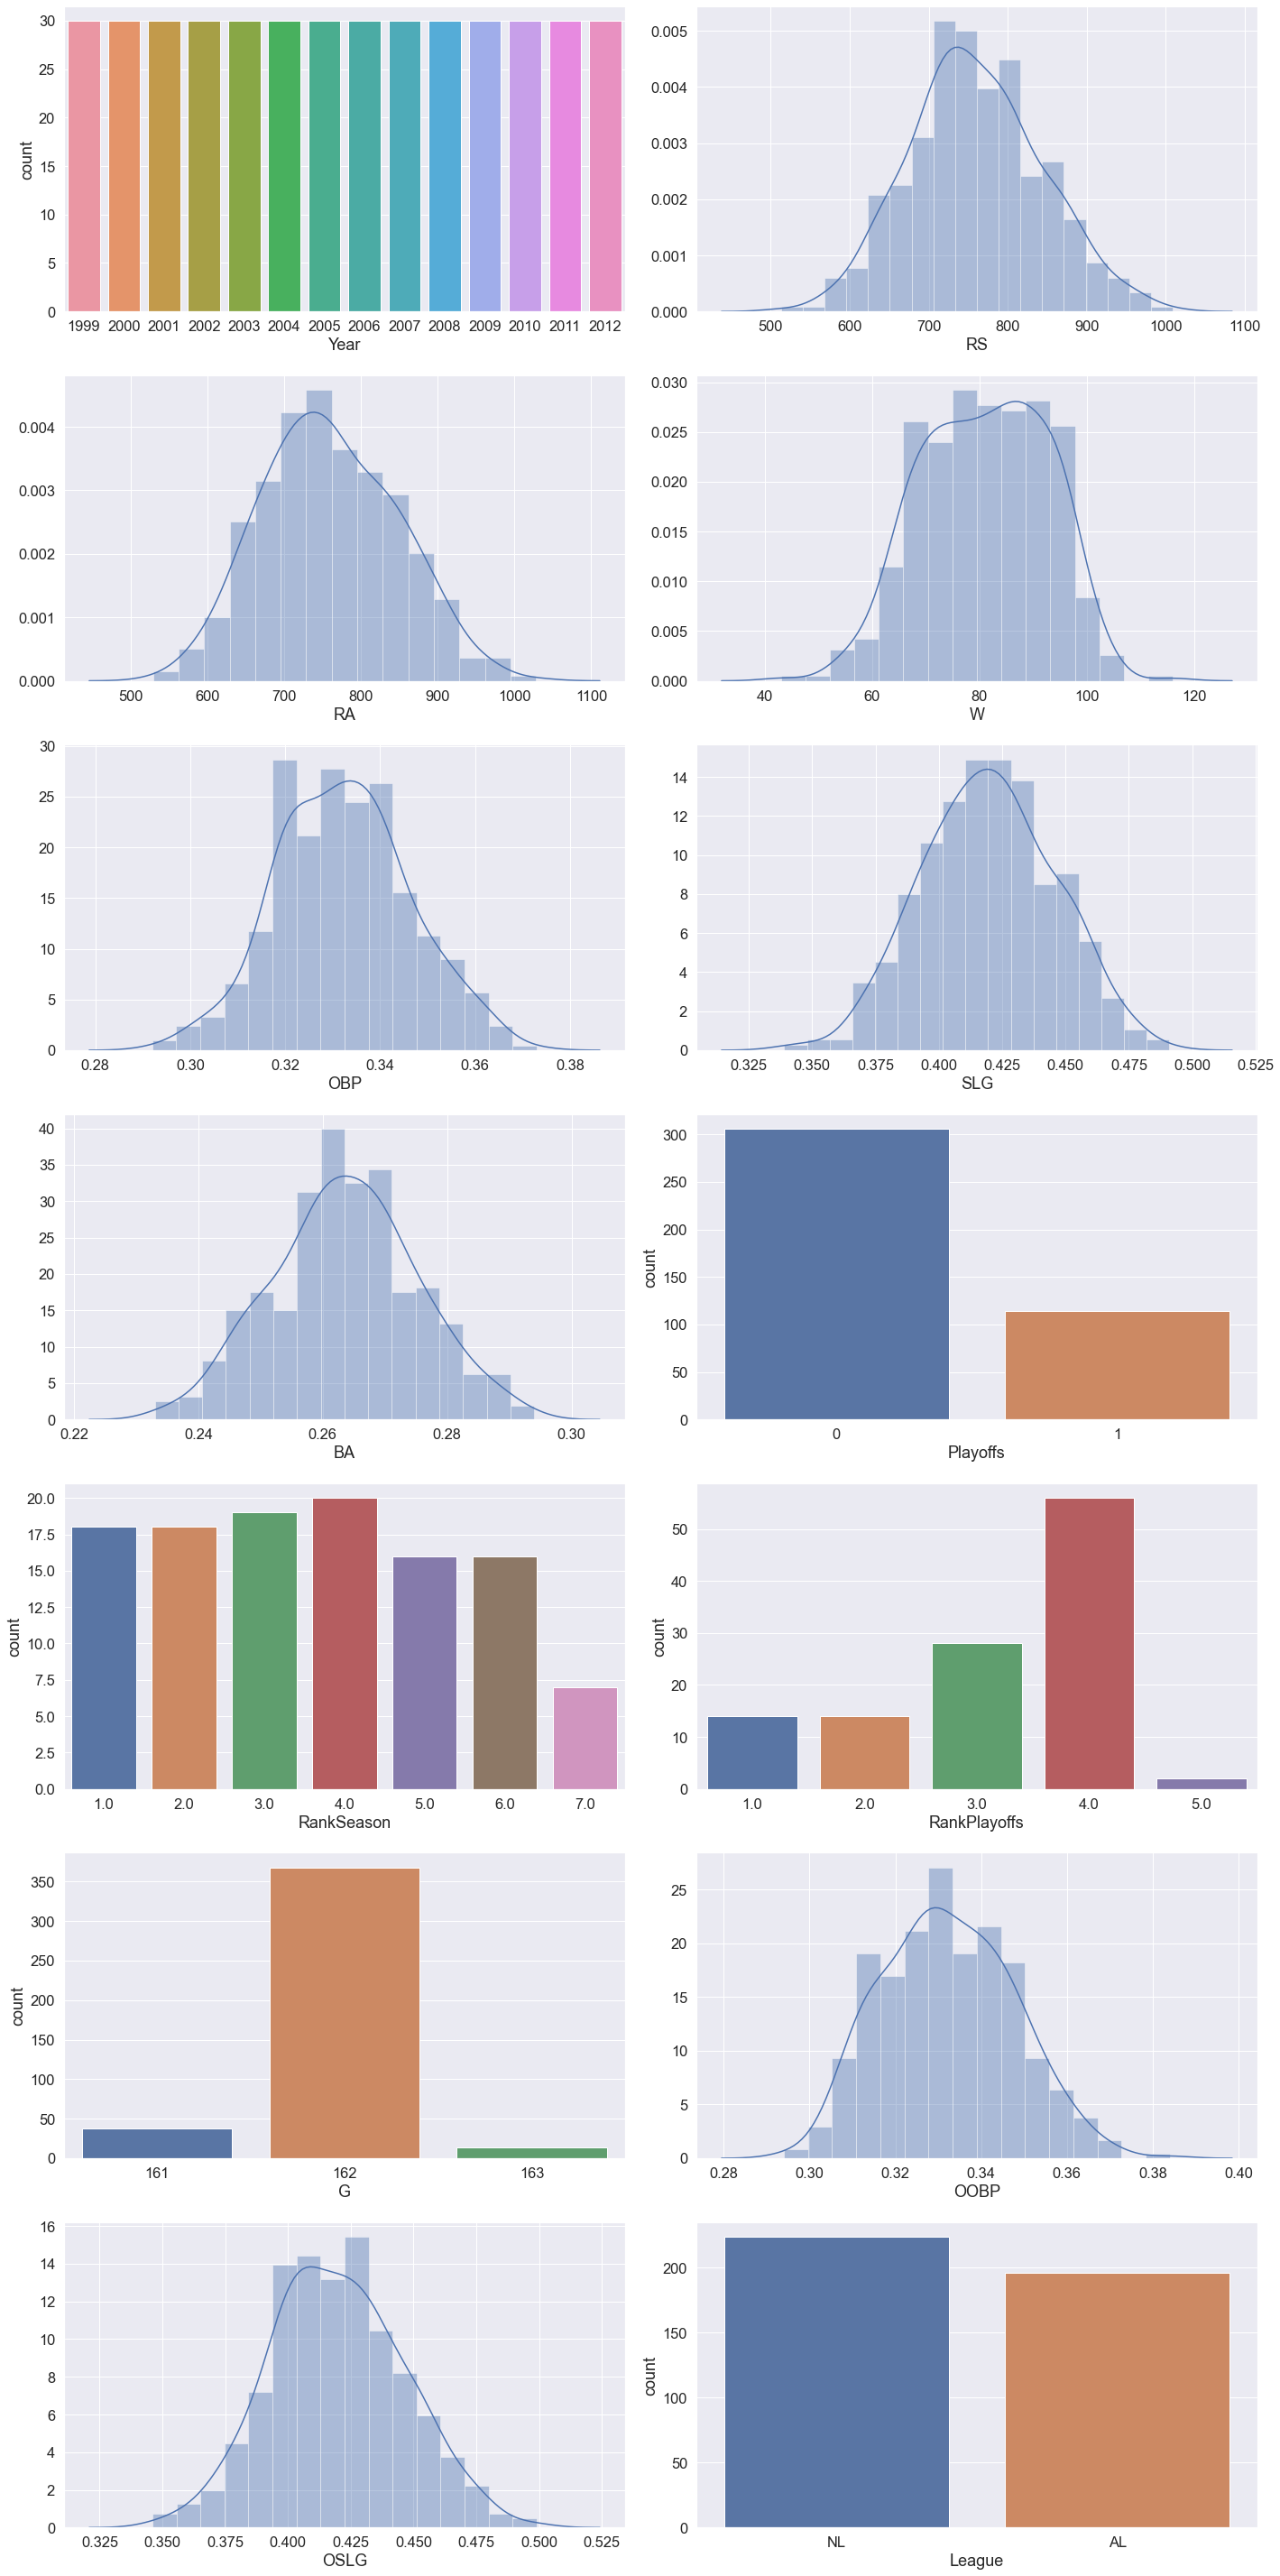

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Year)
plt.subplot(7,2,2)
sns.distplot(df.RS)
plt.subplot(7,2,3)
sns.distplot(df.RA)
plt.subplot(7,2,4)
sns.distplot(df.W)
plt.subplot(7,2,5)
sns.distplot(df.OBP)
plt.subplot(7,2,6)
sns.distplot(df.SLG)
plt.subplot(7,2,7)
sns.distplot(df.BA)
plt.subplot(7,2,8)
sns.countplot(df.Playoffs)
plt.subplot(7,2,9)
sns.countplot(df.RankSeason)
plt.subplot(7,2,10)
sns.countplot(df.RankPlayoffs)
plt.subplot(7,2,11)
sns.countplot(df.G)
plt.subplot(7,2,12)
sns.distplot(df.OOBP)
plt.subplot(7,2,13)
sns.distplot(df.OSLG)
plt.subplot(7,2,14)
sns.countplot(df.League)

plt.tight_layout()
plt.show()

In [9]:
df.corr()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
Year,1.000000,-0.394162,-0.375678,0.002692,-0.402147,-0.349168,-0.329479,0.017266,0.080417,0.047934,0.102071,-0.371869,-0.345667
RS,-0.394162,1.000000,0.198869,0.554444,0.895743,0.910242,0.806596,0.390044,-0.360962,-0.001477,0.127402,0.133981,0.193426
RA,-0.375678,0.198869,1.000000,-0.634540,0.155346,0.213009,0.232224,-0.433023,0.069920,0.053172,-0.037377,0.910344,0.909319
W,0.002692,0.554444,-0.634540,1.000000,0.522941,0.497791,0.393387,0.709942,-0.764191,-0.004507,0.129136,-0.634315,-0.568490
OBP,-0.402147,0.895743,0.155346,0.522941,1.000000,0.773883,0.829507,0.387661,-0.264424,-0.047524,0.083441,0.120349,0.153372
SLG,-0.349168,0.910242,0.213009,0.497791,0.773883,1.000000,0.754388,0.335586,-0.268387,-0.077998,0.110088,0.143861,0.210423
BA,-0.329479,0.806596,0.232224,0.393387,0.829507,0.754388,1.000000,0.285183,-0.164299,-0.108597,0.099764,0.187108,0.227808
Playoffs,0.017266,0.390044,-0.433023,0.709942,0.387661,0.335586,0.285183,1.000000,NaN,NaN,0.054194,-0.433572,-0.366744
RankSeason,0.080417,-0.360962,0.069920,-0.764191,-0.264424,-0.268387,-0.164299,NaN,1.000000,-0.007525,0.065533,0.097731,0.050111
RankPlayoffs,0.047934,-0.001477,0.053172,-0.004507,-0.047524,-0.077998,-0.108597,NaN,-0.007525,1.000000,-0.011897,0.065808,0.087089


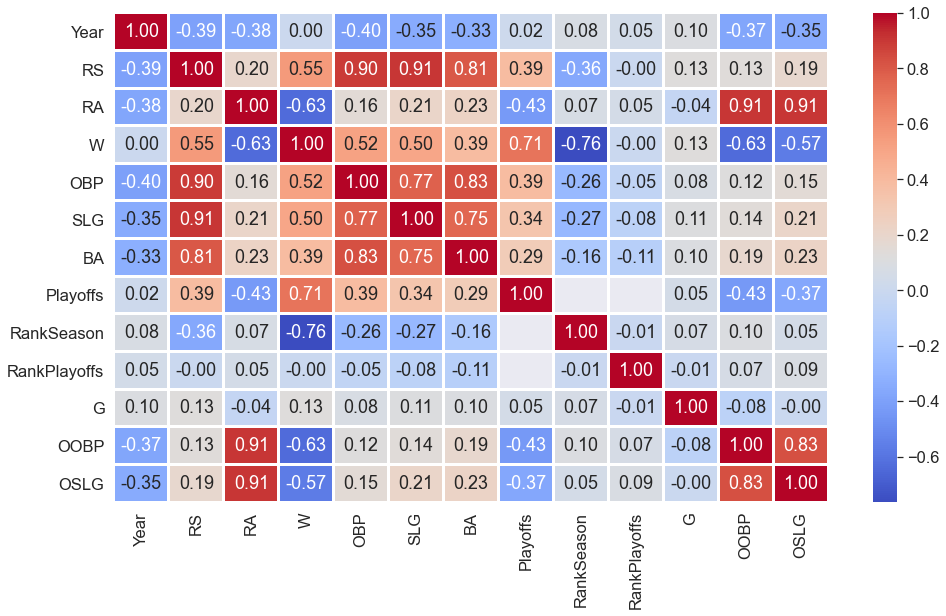

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

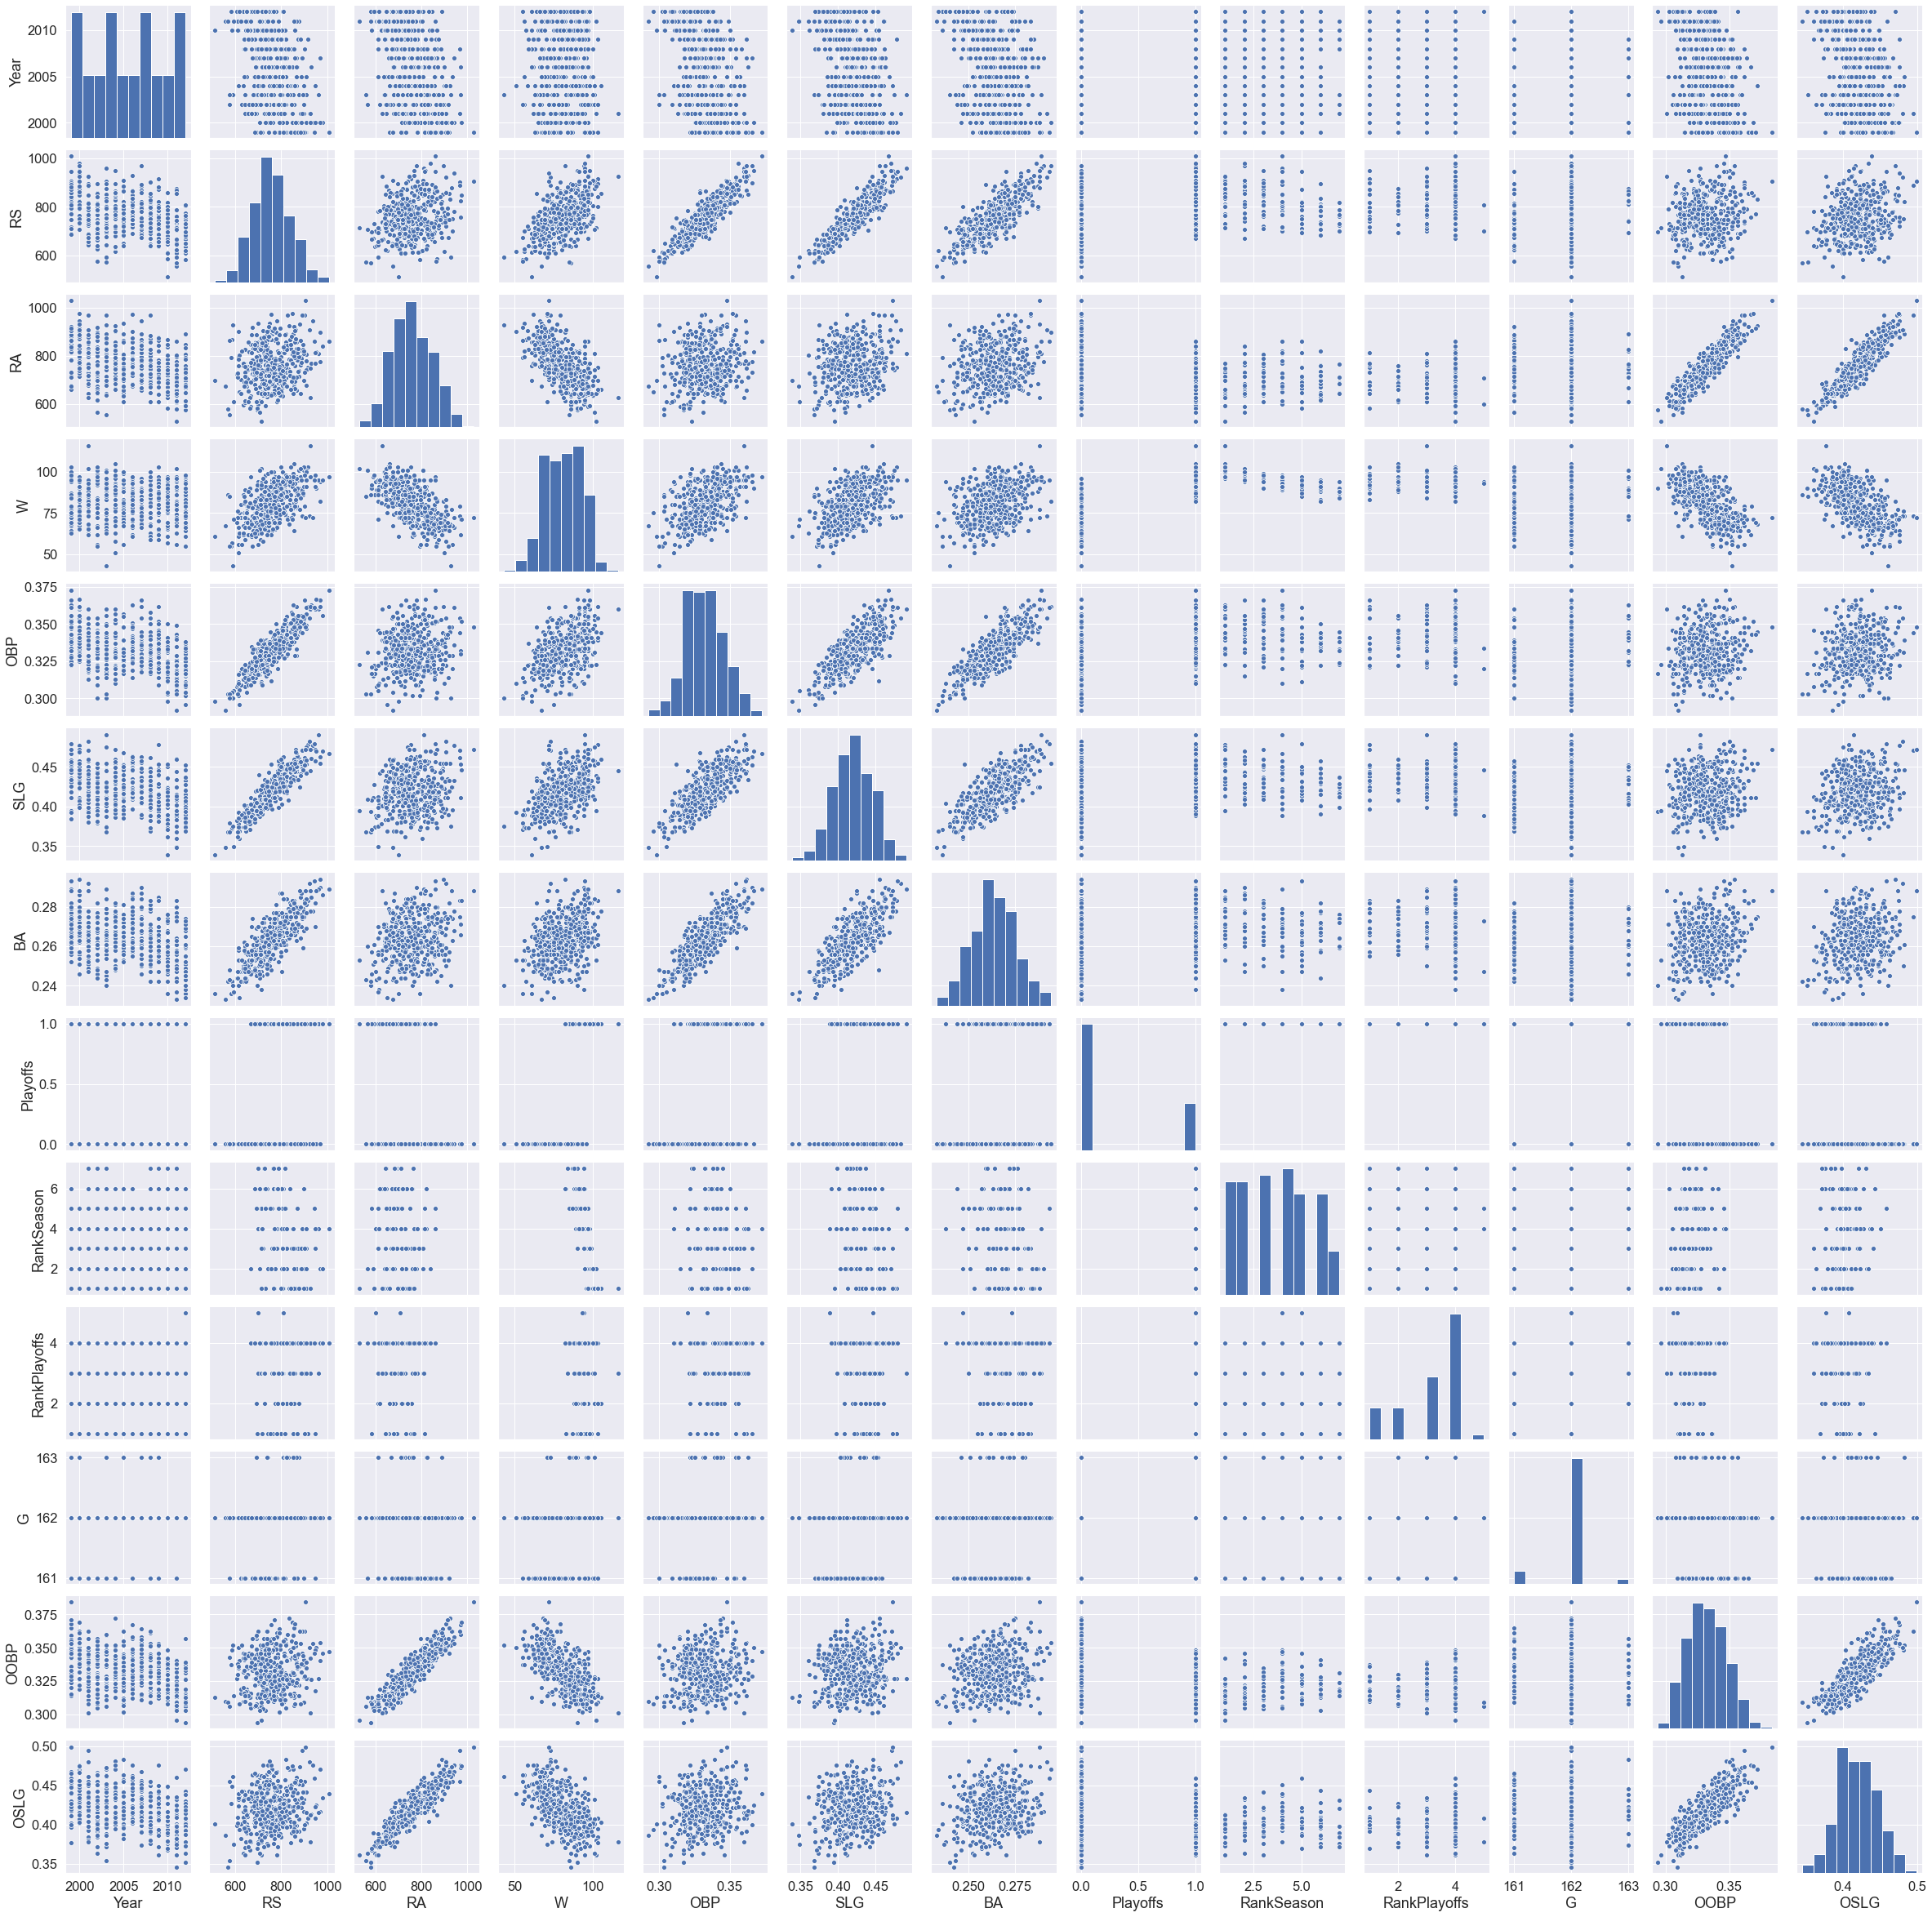

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      306
RankPlayoffs    306
G                 0
OOBP              0
OSLG              0
dtype: int64

In [13]:
imputer = mdi.ArbitraryNumberImputer(arbitrary_number=0.0,variables=['RankSeason','RankPlayoffs'])

In [14]:
imputer.fit(df)

ArbitraryNumberImputer(arbitrary_number=0.0,
                       variables=['RankSeason', 'RankPlayoffs'])

In [15]:
df = imputer.transform(df)

In [16]:
df.isnull().sum()

Team            0
League          0
Year            0
RS              0
RA              0
W               0
OBP             0
SLG             0
BA              0
Playoffs        0
RankSeason      0
RankPlayoffs    0
G               0
OOBP            0
OSLG            0
dtype: int64

### Treat Duplicate Values

In [17]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

### Treat Outliers

In [18]:
df

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,SFG,NL,1999,872,831,86,0.356,0.434,0.271,0,0.0,0.0,162,0.345,0.423
416,STL,NL,1999,809,838,75,0.338,0.426,0.262,0,0.0,0.0,161,0.355,0.427
417,TBD,AL,1999,772,913,69,0.343,0.411,0.274,0,0.0,0.0,162,0.371,0.448
418,TEX,AL,1999,945,859,95,0.361,0.479,0.293,1,5.0,4.0,162,0.346,0.459


In [19]:
df.describe()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,2005.500000,759.538095,759.538095,80.957143,0.332300,0.419729,0.263638,0.271429,0.990476,0.857143,161.942857,0.332264,0.419743
std,4.035936,83.527087,87.636758,11.642162,0.014005,0.026100,0.011584,0.445227,1.884469,1.513210,0.347609,0.015295,0.026510
min,1999.000000,513.000000,529.000000,43.000000,0.292000,0.339000,0.233000,0.000000,0.000000,0.000000,161.000000,0.294000,0.346000
25%,2002.000000,706.000000,697.000000,72.000000,0.322000,0.401750,0.256000,0.000000,0.000000,0.000000,162.000000,0.321000,0.401000
50%,2005.500000,752.500000,754.500000,81.000000,0.332000,0.420000,0.263000,0.000000,0.000000,0.000000,162.000000,0.331000,0.419000
75%,2009.000000,813.000000,823.500000,90.000000,0.341000,0.437000,0.271000,1.000000,1.000000,1.000000,162.000000,0.343000,0.438000
max,2012.000000,1009.000000,1028.000000,116.000000,0.373000,0.491000,0.294000,1.000000,7.000000,5.000000,163.000000,0.384000,0.499000


### Treat Data Types

### Feature Scaling

In [20]:
df.columns

Index(['Team', 'League', 'Year', 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA',
       'Playoffs', 'RankSeason', 'RankPlayoffs', 'G', 'OOBP', 'OSLG'],
      dtype='object')

In [21]:
df.drop(['Team','Year'],axis=1,inplace=True)

In [22]:
df

,League,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,NL,734,688,81,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415
1,NL,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,AL,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,AL,734,806,69,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428
4,NL,613,759,61,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,NL,872,831,86,0.356,0.434,0.271,0,0.0,0.0,162,0.345,0.423
416,NL,809,838,75,0.338,0.426,0.262,0,0.0,0.0,161,0.355,0.427
417,AL,772,913,69,0.343,0.411,0.274,0,0.0,0.0,162,0.371,0.448
418,AL,945,859,95,0.361,0.479,0.293,1,5.0,4.0,162,0.346,0.459


In [23]:
df2 = pd.get_dummies(df,drop_first=True)

In [24]:
df2

,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,League_NL
0,734,688,81,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415,1
1,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,1
2,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,0
3,734,806,69,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428,0
4,613,759,61,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,872,831,86,0.356,0.434,0.271,0,0.0,0.0,162,0.345,0.423,1
416,809,838,75,0.338,0.426,0.262,0,0.0,0.0,161,0.355,0.427,1
417,772,913,69,0.343,0.411,0.274,0,0.0,0.0,162,0.371,0.448,0
418,945,859,95,0.361,0.479,0.293,1,5.0,4.0,162,0.346,0.459,0


In [25]:
df2.columns

Index(['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'Playoffs', 'RankSeason',
       'RankPlayoffs', 'G', 'OOBP', 'OSLG', 'League_NL'],
      dtype='object')

In [26]:
df2 = df2[['RS', 'RA','OBP', 'SLG', 'BA', 'Playoffs', 'RankSeason','RankPlayoffs', 'G', 
           'OOBP', 'OSLG', 'League_NL','W']]

In [27]:
df2

,RS,RA,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,League_NL,W
0,734,688,0.328,0.418,0.259,0,0.0,0.0,162,0.317,0.415,1,81
1,700,600,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378,1,94
2,712,705,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403,0,93
3,734,806,0.315,0.415,0.260,0,0.0,0.0,162,0.331,0.428,0,69
4,613,759,0.302,0.378,0.240,0,0.0,0.0,162,0.335,0.424,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,872,831,0.356,0.434,0.271,0,0.0,0.0,162,0.345,0.423,1,86
416,809,838,0.338,0.426,0.262,0,0.0,0.0,161,0.355,0.427,1,75
417,772,913,0.343,0.411,0.274,0,0.0,0.0,162,0.371,0.448,0,69
418,945,859,0.361,0.479,0.293,1,5.0,4.0,162,0.346,0.459,0,95


In [28]:
features = df2[['RS', 'RA','OBP', 'SLG', 'BA', 'RankSeason','RankPlayoffs', 'G', 'OOBP', 'OSLG']]

In [29]:
features

,RS,RA,OBP,SLG,BA,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,734,688,0.328,0.418,0.259,0.0,0.0,162,0.317,0.415
1,700,600,0.320,0.389,0.247,4.0,5.0,162,0.306,0.378
2,712,705,0.311,0.417,0.247,5.0,4.0,162,0.315,0.403
3,734,806,0.315,0.415,0.260,0.0,0.0,162,0.331,0.428
4,613,759,0.302,0.378,0.240,0.0,0.0,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...
415,872,831,0.356,0.434,0.271,0.0,0.0,162,0.345,0.423
416,809,838,0.338,0.426,0.262,0.0,0.0,161,0.355,0.427
417,772,913,0.343,0.411,0.274,0.0,0.0,162,0.371,0.448
418,945,859,0.361,0.479,0.293,5.0,4.0,162,0.346,0.459


In [30]:
scaler = StandardScaler()

In [31]:
features_scaled = scaler.fit_transform(features)

In [32]:
features_scaled = pd.DataFrame(features_scaled,columns=features.columns)

In [33]:
features_scaled

,RS,RA,OBP,SLG,BA,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,-0.306111,-0.817276,-0.307404,-0.066308,-0.400881,-0.526227,-0.567116,0.164584,-0.999161,-0.179124
1,-0.713650,-1.822618,-0.879318,-1.178752,-1.438067,1.598919,2.741058,0.164584,-1.719194,-1.576509
2,-0.569813,-0.623062,-1.522722,-0.104668,-1.438067,2.130206,2.079424,0.164584,-1.130076,-0.632330
3,-0.306111,0.530797,-1.236765,-0.181389,-0.314448,-0.526227,-0.567116,0.164584,-0.082757,0.311849
4,-1.756470,-0.006147,-2.166126,-1.600714,-2.043092,-0.526227,-0.567116,0.164584,0.179073,0.160780
...,...,...,...,...,...,...,...,...,...,...
415,1.348018,0.816405,1.694296,0.547454,0.636305,-0.526227,-0.567116,0.164584,0.833648,0.123013
416,0.592872,0.896376,0.407489,0.240573,-0.141584,-0.526227,-0.567116,-2.715643,1.488222,0.274082
417,0.149374,1.753202,0.764936,-0.334829,0.895602,-0.526227,-0.567116,0.164584,2.535542,1.067192
418,2.223028,1.136287,2.051743,2.273660,2.537813,2.130206,2.079424,0.164584,0.899105,1.482631


In [34]:
remains = df2[['Playoffs','League_NL','W']]

In [35]:
remains

,Playoffs,League_NL,W
0,0,1,81
1,1,1,94
2,1,0,93
3,0,0,69
4,0,1,61
...,...,...,...
415,0,1,86
416,0,1,75
417,0,0,69
418,1,0,95


In [36]:
df3 = pd.concat([features_scaled,remains],axis=1)

In [37]:
df3

,RS,RA,OBP,SLG,BA,RankSeason,RankPlayoffs,G,OOBP,OSLG,Playoffs,League_NL,W
0,-0.306111,-0.817276,-0.307404,-0.066308,-0.400881,-0.526227,-0.567116,0.164584,-0.999161,-0.179124,0,1,81
1,-0.713650,-1.822618,-0.879318,-1.178752,-1.438067,1.598919,2.741058,0.164584,-1.719194,-1.576509,1,1,94
2,-0.569813,-0.623062,-1.522722,-0.104668,-1.438067,2.130206,2.079424,0.164584,-1.130076,-0.632330,1,0,93
3,-0.306111,0.530797,-1.236765,-0.181389,-0.314448,-0.526227,-0.567116,0.164584,-0.082757,0.311849,0,0,69
4,-1.756470,-0.006147,-2.166126,-1.600714,-2.043092,-0.526227,-0.567116,0.164584,0.179073,0.160780,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1.348018,0.816405,1.694296,0.547454,0.636305,-0.526227,-0.567116,0.164584,0.833648,0.123013,0,1,86
416,0.592872,0.896376,0.407489,0.240573,-0.141584,-0.526227,-0.567116,-2.715643,1.488222,0.274082,0,1,75
417,0.149374,1.753202,0.764936,-0.334829,0.895602,-0.526227,-0.567116,0.164584,2.535542,1.067192,0,0,69
418,2.223028,1.136287,2.051743,2.273660,2.537813,2.130206,2.079424,0.164584,0.899105,1.482631,1,0,95


### Create and save processed dataset

In [38]:
#df3.to_csv("baseballtrain.csv",index=False)

### Model Training

In [39]:
df3.shape

(420, 13)

In [40]:
X = df3.iloc[:,0:12]
y = df3.iloc[:,12]

In [41]:
X.values, y.values

(array([[-0.30611091, -0.81727592, -0.30740399, ..., -0.17912422,
          0.        ,  1.        ],
        [-0.71364994, -1.82261832, -0.8793184 , ..., -1.57650896,
          1.        ,  1.        ],
        [-0.56981264, -0.62306204, -1.5227221 , ..., -0.63233008,
          1.        ,  0.        ],
        ...,
        [ 0.1493739 ,  1.75320182,  0.76493552, ...,  1.0671919 ,
          0.        ,  0.        ],
        [ 2.22302842,  1.13628716,  2.05174293, ...,  1.48263061,
          1.        ,  0.        ],
        [ 1.479869  ,  1.1705602 ,  1.40833922, ...,  1.36932914,
          0.        ,  0.        ]]),
 array([ 81,  94,  93,  69,  61,  85,  97,  68,  64,  88,  55,  72,  89,
         86,  69,  83,  66,  74,  95,  94,  81,  79,  76,  75,  94,  88,
         90,  93,  73,  98,  94,  89,  69,  90,  71,  79,  79,  80,  73,
         95,  72,  56,  71,  86,  82,  96,  63,  77,  97,  74, 102,  72,
         71,  67,  86,  90,  91,  96,  81,  80,  65,  91,  66,  89,  75,
        

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((336, 12), (84, 12), (336,), (84,))

### Using XGBoost

In [44]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [45]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:73.9683
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:66.7121
[2]	validation_0-rmse:60.1728
[3]	validation_0-rmse:54.3509
[4]	validation_0-rmse:49.2158
[5]	validation_0-rmse:44.5401
[6]	validation_0-rmse:40.2775
[7]	validation_0-rmse:36.5559
[8]	validation_0-rmse:33.0243
[9]	validation_0-rmse:29.9711
[10]	validation_0-rmse:27.1983
[11]	validation_0-rmse:24.7359
[12]	validation_0-rmse:22.5275
[13]	validation_0-rmse:20.4479
[14]	validation_0-rmse:18.6533
[15]	validation_0-rmse:17.0646
[16]	validation_0-rmse:15.6588
[17]	validation_0-rmse:14.3177
[18]	validation_0-rmse:13.0966
[19]	validation_0-rmse:12.0182
[20]	validation_0-rmse:11.0668
[21]	validation_0-rmse:10.2264
[22]	validation_0-rmse:9.47007
[23]	validation_0-rmse:8.78667
[24]	validation_0-rmse:8.23806
[25]	validation_0-rmse:7.76166
[26]	validation_0-rmse:7.33626
[27]	validation_0-rmse:6.94738
[28]	validation_0-rmse:6.5832
[29]	validation_0-rmse:6.27736
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [46]:
y_pred = xgbmodel.predict(X_test)

In [47]:
y_pred

array([100.34005 ,  78.65588 ,  82.734695,  73.99137 ,  74.3489  ,
        69.816505,  63.25927 ,  87.34093 ,  74.122665,  70.60758 ,
        98.38636 ,  91.58229 ,  81.85766 ,  74.56171 ,  81.17518 ,
        74.64761 ,  68.00982 ,  72.66954 , 101.10807 ,  71.05022 ,
        87.230484,  73.90757 ,  77.0263  ,  84.128914,  95.7179  ,
        93.83143 ,  69.41444 ,  86.49817 ,  86.29616 ,  82.03212 ,
        67.49944 ,  76.447685,  96.808815,  82.68773 ,  91.256714,
        77.961174,  85.24053 ,  74.879974,  71.18477 ,  96.028244,
        78.058266,  84.61969 ,  94.851166,  72.914505,  84.46847 ,
        63.924408, 100.81676 ,  81.743004,  72.273575,  95.80182 ,
        77.64077 ,  64.48494 ,  82.64259 ,  93.99476 ,  69.5581  ,
        84.35634 ,  96.60617 ,  93.28968 ,  95.56851 ,  67.66978 ,
        91.03682 ,  50.969845,  68.32197 ,  65.67375 ,  98.6478  ,
        65.02402 ,  95.55933 ,  91.274   ,  83.97332 ,  80.78424 ,
        97.54834 ,  63.827522,  77.453415,  72.20455 ,  88.670

### Model Evaluation

In [48]:
mse = mean_squared_error(y_test,y_pred)
mse

17.607127166752477

In [49]:
rmse = np.sqrt(mse)
rmse

4.196084742560912

In [50]:
r2score = r2_score(y_test,y_pred)
r2score

0.867398975052587

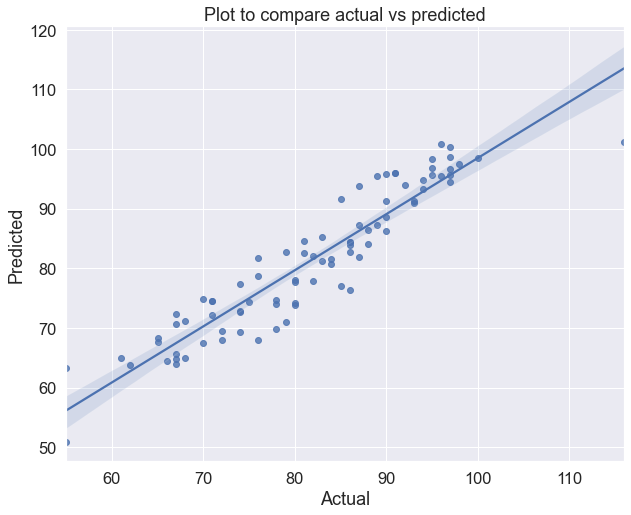

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

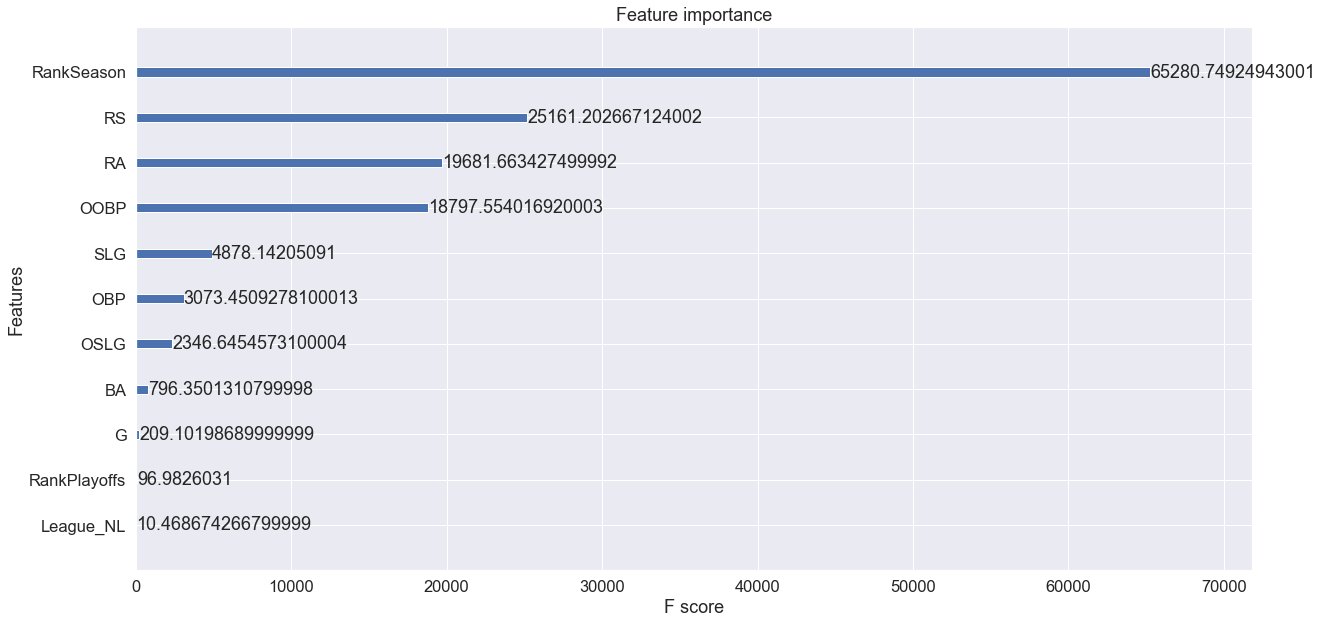

In [52]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgbmodel,ax=ax, importance_type='total_gain')
plt.show()

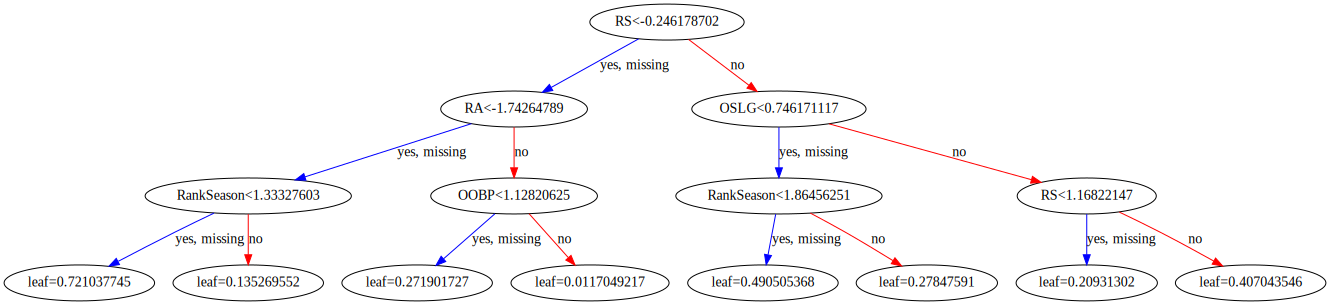

In [53]:
xgb.to_graphviz(xgbmodel,num_trees=30)

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [54]:
cv = cross_val_score(xgbmodel,X,y,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [55]:
cv.mean()

0.866894813219379

### Model Tuning

In [56]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [57]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [58]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='r2')

In [59]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [60]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=34,
             importance_type='gain', learning rate=0.14, learning_rate=0.1,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7, verbosity=1)

In [61]:
randm.best_score_

0.8884783814157151

In [62]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 300,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning rate': 0.14,
 'gamma': 34,
 'colsample_bytree': 0.7999999999999999}